## Language translation using Seq-to-Seq model

Our aim is to translate sentences in German to English.

Importing the modules

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.python import keras
from keras.models import  Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras_preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

Loading the data

In [2]:
def read_text(filename):
  file = open(filename, mode='rt', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [3]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [4]:
data = read_text("./deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng = deu_eng[:50000, :]

Text Cleaning / Preprocessing

In [6]:
#Removing punctuations
deu_eng[:,0] = [s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:,1]]

deu_eng[:5]

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ['Wow', 'Potzdonner'],
       ['Wow', 'Donnerwetter']], dtype='<U380')

In [7]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

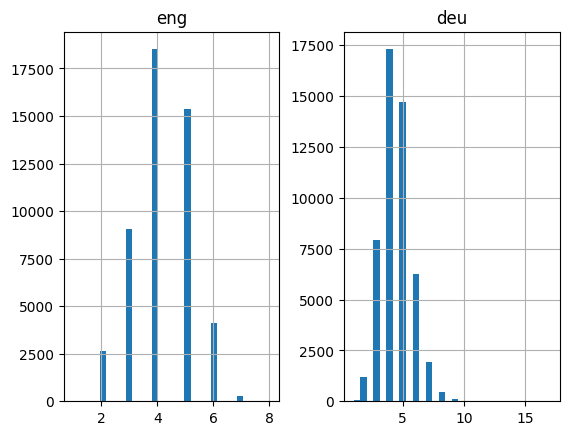

In [8]:
eng_1 = []
deu_1 = []

#populating the lists with the sentence length
for i in deu_eng[:,0]:
  eng_1.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_1.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_1, 'deu':deu_1})
length_df.hist(bins=30)
plt.show()

In [9]:
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [10]:
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index)+1

eng_length = 8
print('English vocabulary size is %d'% eng_vocab_size)

English vocabulary size is 6794


In [11]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index)+1

deu_length = 8
print('Deutch vocabulary size is %d'% deu_vocab_size)

Deutch vocabulary size is 11814


In [12]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [13]:
from sklearn.model_selection import train_test_split
#splitting data into train and test set
train,test = train_test_split(deu_eng, test_size=0.2, random_state=12)

In [14]:
#preparing training and validation data
x_train = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

x_test = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Defining the model

In [15]:
#build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [16]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [17]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Fit the model

In [18]:
filename = 'model_02_aug_24.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#training the model
history = model.fit(x_train, y_train.reshape(y_train.shape[0], y_train.shape[1],1),
                    epochs=30, batch_size=256, validation_split=0.2,
                    callbacks=[checkpoint], verbose=1)

Epoch 1/30

125/125 [==============================] - ETA: 0s - loss: 4.1030
Epoch 1: val_loss improved from inf to 3.31568, saving model to model_02_aug_24.keras
125/125 [==============================] - 208s 2s/step - loss: 4.1030 - val_loss: 3.3157
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 3.2685
Epoch 2: val_loss improved from 3.31568 to 3.22259, saving model to model_02_aug_24.keras
125/125 [==============================] - 205s 2s/step - loss: 3.2685 - val_loss: 3.2226
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 3.2000
Epoch 3: val_loss improved from 3.22259 to 3.18907, saving model to model_02_aug_24.keras
125/125 [==============================] - 203s 2s/step - loss: 3.2000 - val_loss: 3.1891
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 3.1659
Epoch 4: val_loss improved from 3.18907 to 3.18380, saving model to model_02_aug_24.keras
125/125 [==============================] - 202s 2s/step - loss: 3

Evaluating the model

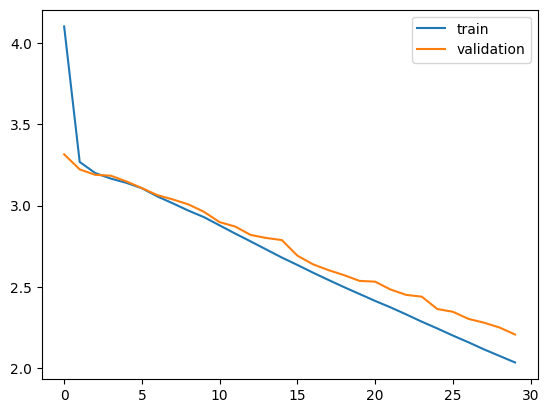

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Prediction on unseen data

In [ ]:
model = load_model('model_02_aug_24.keras')
pred_probs = model.predict(x_test.reshape((x_test.shape[0], x_test.shape[1])))
pred_classes = pred_probs.argmax(axis=-1)

In [22]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index==n:
      return word
  return None

In [ ]:
pred_text = []
for i in pred_classes:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j>0:
      if(t==get_word(i[j], eng_tokenizer)) or (t==None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t==None):
        temp.append('')
      else:
        temp.append(t)
  pred_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted':pred_text})

In [ ]:
pred_df.head(20)